# Keras API programme on Deep Learning (Parallel Architecture) 

# Tutorial 2: Introduction to Keras: Python Deep Learning Library and a Powerful API 

In this tutorial, we provide you a brief introduction to Keras Application Program Interface (API).

* Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow. 
* Developed for enabling fast experimentation.
* Keras is compatible with: Python 2.7-3.6. 
* In 2017, Google's TensorFlow team decided to support Keras in TensorFlow's core library. So now, Tensorflow is one of the backend supports for Keras apart from Theano and CNTK. 

Source: Official website of Keras. (https://keras.io/)

In this guide, you will learn how to:

* prepare and preprocess Data 
* build a machine learning model 
* train a model and
* perform Model Evaluation

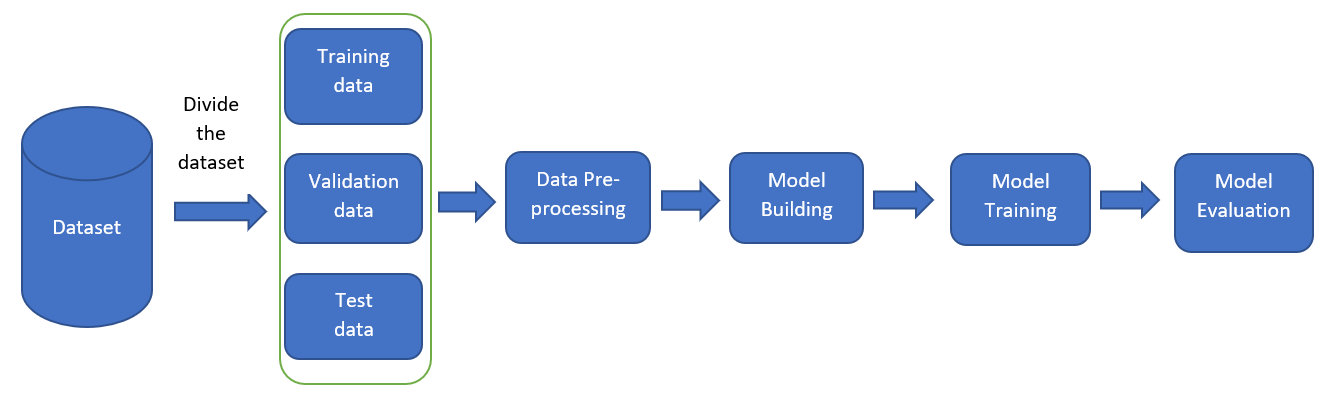

**1. Import necessary libraries**

**Data Preparation**

* Neural networks don't process raw data, like text files, encoded JPEG image files, or CSV files. They process vectorized & standardized representations.

* Text files need to be read into string tensors, then split into words. Finally, the words need to be indexed & turned into integer tensors.
* Images need to be read and decoded into integer tensors, then converted to floating point and normalized to small values (usually between 0 and 1).
* CSV data needs to be parsed, with numerical features converted to floating point tensors and categorical features indexed and converted to integer tensors. Then each feature typically needs to be normalized to zero-mean and unit-variance.

Keras models accept three types of inputs:

- **NumPy arrays**, just like Scikit-Learn and many other Python-based libraries. This
 is a good option if your data fits in memory.
- **[TensorFlow `Dataset` objects](https://www.tensorflow.org/guide/data)**. This is a
high-performance option that is more suitable for datasets that do not fit in memory
 and that are streamed from disk or from a distributed filesystem.
- **Python generators** that yield batches of data (such as custom subclasses of
the `keras.utils.Sequence` class).



For a large dataset consider using `Dataset` objects, since they will take care of performance.

Keras features a range of utilities to help you turn raw data on disk into a `Dataset`:

- `tf.keras.preprocessing.image_dataset_from_directory` turns image files sorted into
 class-specific folders into a labeled dataset of image tensors.
- `tf.keras.preprocessing.text_dataset_from_directory` does the same for text files.

In addition, the TensorFlow `tf.data` includes other similar utilities, such as
`tf.data.experimental.make_csv_dataset` to load structured data from CSV files.

**Example: obtaining a labeled dataset from image files on disk**

Supposed you have image files sorted by class in different folders, like this:

```
dataset/
...cat/
......cat_1.jpg
......cat_2.jpg
...dog/
......dog_1.jpg
......dog_2.jpg
```

Then you can do:

```python
# Create a dataset.
dataset = keras.preprocessing.image_dataset_from_directory(
  'path/to/main_directory', batch_size=64, image_size=(200, 200))

# For demonstration, iterate over the batches yielded by the dataset.
for data, labels in dataset:
   print(data.shape)  # (64, 200, 200, 3)
   print(data.dtype)  # float32
   print(labels.shape)  # (64,)
   print(labels.dtype)  # int32
```

The label of a sample is the rank of its folder in alphanumeric order. Naturally, this
 can also be configured explicitly by passing, e.g.
`class_names=['class_a', 'class_b']`, in which cases label `0` will be `class_a` and
 `1` will be `class_b`.

**Example: obtaining a labeled dataset from text files on disk**

Likewise for text: if you have `.txt` documents sorted by class in different folders,
 you can do:

```python
dataset = keras.preprocessing.text_dataset_from_directory(
  'path/to/main_directory', batch_size=64)

# For demonstration, iterate over the batches yielded by the dataset.
for data, labels in dataset:
   print(data.shape)  # (64,)
   print(data.dtype)  # string
   print(labels.shape)  # (64,)
   print(labels.dtype)  # int32
```



## Data Preprocessing

Once data is in the form of string/int/float NumpPy arrays, or a `Dataset` object
 (or Python generator) that yields batches of string/int/float tensors,
it is time to **preprocess** the data. This can mean:

- Tokenization of string data, followed by token indexing.
- Feature normalization.
- Rescaling the data to small values (in general, input values to a neural network
should be close to zero -- typically either data with zero-mean and
 unit-variance, or data in the `[0, 1]` range.


### Using Keras preprocessing layers

In Keras, you do in-model data preprocessing via **preprocessing layers**. This
 includes:

- Vectorizing raw strings of text via the `TextVectorization` layer
- Feature normalization via the `Normalization` layer
- Image rescaling, cropping, or image data augmentation

The key advantage of using Keras preprocessing layers is that **they can be included
 directly into your model**, either during training or after training,
which makes your models portable.

Some preprocessing layers have a state:

- `TextVectorization` holds an index mapping words or tokens to integer indices
- `Normalization` holds the mean and variance of your features

The state of a preprocessing layer is obtained by calling `layer.adapt(data)` on a
 sample of the training data (or all of it).

 **Example: turning strings into sequences of integer word indices**

In [ ]:
import numpy as np

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Example training data, of dtype `string`.
training_data = np.array([["This is the 1st sample."], ["And here's the 2nd sample."]])

# Create a TextVectorization layer instance. It can be configured to either
# return integer token indices, or a dense token representation (e.g. multi-hot
# or TF-IDF). The text standardization and text splitting algorithms are fully
# configurable.
vectorizer = TextVectorization(output_mode="int")

# Calling `adapt` on an array or dataset makes the layer generate a vocabulary
# index for the data, which can then be reused when seeing new data.
vectorizer.adapt(training_data)

# After calling adapt, the layer is able to encode any n-gram it has seen before
# in the `adapt()` data. Unknown n-grams are encoded via an "out-of-vocabulary"
# token.
integer_data = vectorizer(training_data)
print(integer_data)

tf.Tensor(
[[4 5 2 9 3]
 [7 6 2 8 3]], shape=(2, 5), dtype=int64)


**Example: Feature Normalization**

In [ ]:
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import Normalization

# Example image data, with values in the [0, 255] range
training_data = np.random.randint(0, 256, size=(64, 200, 200, 3)).astype("float32")

normalizer = Normalization(axis=-1)
normalizer.adapt(training_data)

normalized_data = normalizer(training_data)
print("var: %.4f" % np.var(normalized_data))
print("mean: %.4f" % np.mean(normalized_data))

var: 1.0006
mean: -0.0000


**Example: rescaling & center-cropping images**

Both the `Rescaling` layer and the `CenterCrop` layer are stateless, so it isn't
 necessary to call `adapt()` in this case.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import CenterCrop
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Example image data, with values in the [0, 255] range
training_data = np.random.randint(0, 256, size=(64, 200, 200, 3)).astype("float32")

cropper = CenterCrop(height=150, width=150)
scaler = Rescaling(scale=1.0 / 255)

output_data = scaler(cropper(training_data))
print("shape:", output_data.shape)
print("min:", np.min(output_data))
print("max:", np.max(output_data))

shape: (64, 150, 150, 3)
min: 0.0
max: 1.0


## Building models with the Keras Functional API

A "layer" is a simple input-output transformation (such as the scaling &
center-cropping transformations above). For instance, here's a linear projection layer
 that maps its inputs to a 16-dimensional feature space:

```python
dense = keras.layers.Dense(units=16)
```

A "model" is a directed acyclic graph of layers. You can think of a model as a
"bigger layer" that encompasses multiple sublayers and that can be trained via exposure
 to data.

The most common and most powerful way to build Keras models is the Functional API. To
build models with the Functional API, you start by specifying the shape (and
optionally the dtype) of your inputs. If any dimension of your input can vary, you can
specify it as `None`. For instance, an input for 200x200 RGB image would have shape
`(200, 200, 3)`, but an input for RGB images of any size would have shape `(None,
 None, 3)`.

The Functional API also makes it easy to build models that have multiple inputs (for
instance, an image *and* its metadata) or multiple outputs (for instance, predicting
the class of the image *and* the likelihood that a user will click on it). For a
 deeper dive into what you can do, see our
[guide to the Functional API](/guides/functional_api/).

## Training models with `fit()`

At this point, you know:

- How to prepare your data (e.g. as a NumPy array or a `tf.data.Dataset` object)
- How to build a model that will process your data

The next step is to train your model on your data. The `Model` class features a
built-in training loop, the `fit()` method. It accepts `Dataset` objects, Python
 generators that yield batches of data, or NumPy arrays.

Before you can call `fit()`, you need to specify an optimizer and a loss function (we
 assume you are already familiar with these concepts). This is the `compile()` step:

```python
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              loss=keras.losses.CategoricalCrossentropy())
```

Loss and optimizer can be specified via their string identifiers (in this case
their default constructor argument values are used):


```python
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
```

Once your model is compiled, you can start "fitting" the model to the data.
Here's what fitting a model looks like with NumPy data:

```python
model.fit(numpy_array_of_samples, numpy_array_of_labels,
          batch_size=32, epochs=10)
```

Besides the data, you have to specify two key parameters: the `batch_size` and
the number of epochs (iterations on the data). Here our data will get sliced on batches
 of 32 samples, and the model will iterate 10 times over the data during training.

Here's what fitting a model looks like with a dataset:

```python
model.fit(dataset_of_samples_and_labels, epochs=10)
```

Since the data yielded by a dataset is expected to be already batched, you don't need to
 specify the batch size here.

Let's look at it in practice with a toy example model that learns to classify MNIST
 digits:

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf
# Get the data as Numpy arrays
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train,x_val, y_train, y_val = train_test_split(x_train, y_train, test_size =0.2, shuffle = True )

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(48000, 28, 28)
(10000, 28, 28)
(12000, 28, 28)


In [ ]:

# Build a simple model
from tensorflow import keras
inputs = keras.Input(shape=(28, 28))
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
x = layers.Flatten()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 28, 28)            0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                170   

In [ ]:
# Compile the model
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer= opt, loss="sparse_categorical_crossentropy", metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val), validation_batch_size=16)

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 2.1512 - acc: 0.1962 - val_loss: 1.9403 - val_acc: 0.3448
Epoch 2/10
1500/1500 [==============================] - 4s 3ms/step - loss: 1.6308 - acc: 0.5319 - val_loss: 1.3253 - val_acc: 0.6769
Epoch 3/10
1500/1500 [==============================] - 4s 2ms/step - loss: 1.0628 - acc: 0.7494 - val_loss: 0.8624 - val_acc: 0.7893
Epoch 4/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.7410 - acc: 0.8064 - val_loss: 0.6510 - val_acc: 0.8218
Epoch 5/10
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5963 - acc: 0.8341 - val_loss: 0.5493 - val_acc: 0.8445
Epoch 6/10
1500/1500 [==============================] - 4s 3ms/step - loss: 0.5191 - acc: 0.8538 - val_loss: 0.4888 - val_acc: 0.8597
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4691 - acc: 0.8680 - val_loss: 0.4465 - val_acc: 0.8711
Epoch 8/10
1500/1500 [==============================] - 3s 2ms

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3610 - acc: 0.8934


[0.3610243499279022, 0.8934000134468079]

The fit() call returns a "history" object which records what happened over the course of training. The history.history dict contains per-epoch timeseries of metrics values (here we have only one metric, the loss, and one epoch, so we only get a single scalar):

In [ ]:
print(history.history)

{'loss': [2.151151657104492, 1.6307525634765625, 1.0628036260604858, 0.7409921288490295, 0.5962861180305481, 0.5191230773925781, 0.4690853953361511, 0.4325782060623169, 0.4047172963619232, 0.38273006677627563], 'acc': [0.19620832800865173, 0.5319166779518127, 0.7494375109672546, 0.8064374923706055, 0.8341041803359985, 0.8537708520889282, 0.8680416941642761, 0.8787708282470703, 0.8864583373069763, 0.8928124904632568], 'val_loss': [1.940303921699524, 1.325285792350769, 0.8624138832092285, 0.651046633720398, 0.5493143200874329, 0.4887595474720001, 0.4465436637401581, 0.4150466024875641, 0.39085623621940613, 0.37333664298057556], 'val_acc': [0.3448333442211151, 0.6769166588783264, 0.7893333435058594, 0.8218333125114441, 0.8445000052452087, 0.859749972820282, 0.8710833191871643, 0.8797500133514404, 0.8879166841506958, 0.8943333625793457]}


### Keeping track of performance metrics

As you're training a model, you want to keep track of metrics such as classification
accuracy, precision, recall, AUC, etc. Besides, you want to monitor these metrics not
 only on the training data, but also on a validation set.

**Monitoring metrics**

You can pass a list of metric objects to `compile()`, like this:


**Passing validation data to `fit()`**

You can pass validation data to `fit()` to monitor your validation loss & validation
 metrics. Validation metrics get reported at the end of each epoch.

```
# val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
# history = model.fit(dataset, epochs=1, validation_data=val_dataset)
```

### Using callbacks for checkpointing (and more)

If training goes on for more than a few minutes, it's important to save your model at
 regular intervals during training. You can then use your saved models
to restart training in case your training process crashes (this is important for
multi-worker distributed training, since with many workers at least one of them is
 bound to fail at some point).

An important feature of Keras is **callbacks**, configured in `fit()`. Callbacks are
 objects that get called by the model at different point during training, in particular:

- At the beginning and end of each batch
- At the beginning and end of each epoch

Callbacks are a way to make model trainable entirely scriptable.

You can use callbacks to periodically save your model. Here's a simple example: a
 `ModelCheckpoint` callback
configured to save the model at the end of every epoch. The filename will include the
 current epoch.

```python
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='path/to/my/model_{epoch}',
        save_freq='epoch')
]
model.fit(dataset, epochs=2, callbacks=callbacks)
```

You can also use callbacks to do things like periodically changing the learning of your
optimizer, streaming metrics to a Slack bot, sending yourself an email notification
 when training is complete, etc.

For detailed overview of what callbacks are available and how to write your own, see
the [callbacks API documentation](/api/callbacks/) and the
[guide to writing custom callbacks](/guides/writing_your_own_callbacks/).



### After `fit()`: evaluating test performance & generating predictions on new data

Once you have a trained model, you can evaluate its loss and metrics on new data via
 `evaluate()`:

```
loss, acc = model.evaluate(val_dataset)  # returns loss and metrics
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)
```

You can also generate NumPy arrays of predictions (the activations of the output layer(s) in the model) via predict():

```
predictions = model.predict(val_dataset)
print(predictions.shape)
```

Content from: https://keras.io/getting_started/intro_to_keras_for_engineers/